In [3]:
import torch
torch.cuda.is_available() # if True, GPU is available.

True

Currently, all dataset is under `data`.
Split the dataset.

In [4]:
import os
import random
import shutil

# Define paths
data_dir = 'data'

train_dir = 'split/train'
val_dir = 'split/val'
test_dir = 'split/test'

# Define split ratios
train_ratio = 0.75
val_ratio = 0.1
test_ratio = 0.15

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate over each class
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    
    # Create class directories in train, val, and test
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
    
    # Get list of files in the class directory
    files = os.listdir(class_dir)
    random.shuffle(files)  # Shuffle the files
    
    # Calculate split indices
    train_split = int(len(files) * train_ratio)
    val_split = train_split + int(len(files) * val_ratio)
    
    # Split files into train, val, and test
    train_files = files[:train_split]
    val_files = files[train_split:val_split]
    test_files = files[val_split:]
    
    # Move files to respective directories
    for file in train_files:
        shutil.move(os.path.join(class_dir, file), os.path.join(train_dir, class_name, file))
    
    for file in val_files:
        shutil.move(os.path.join(class_dir, file), os.path.join(val_dir, class_name, file))
    
    for file in test_files:
        shutil.move(os.path.join(class_dir, file), os.path.join(test_dir, class_name, file))

print("Data split completed!")

Data split completed!


In [ ]:
from resnet_classifier import *
from pathlib import Path
from datetime import datetime

# Configuration
DATA_ROOT = Path("split")  # Update this path
train_path = DATA_ROOT/"train"
val_path = DATA_ROOT/"val"
test_path = DATA_ROOT/"test"

model_config = {
    "num_classes": 3,
    "resnet_version": 101,
    "train_path": train_path,
    "val_path": val_path,
    "test_path": test_path,
    "optimizer": "adam",
    "lr": 1e-3,
    "batch_size": 32,
    "transfer": True,
    "tune_fc_only": True
}

# Initialize model
model = ResNetClassifier(**model_config)


# Create a timestamp and get architecture name
now = datetime.now().strftime("%Y%m%d_%H%M%S")
arch = f"resnet{model_config['resnet_version']}"

# Training setup
checkpoint_cb = ModelCheckpoint(
    # Save checkpoints inside "checkpoints/{now}" folder.
    dirpath=f"checkpoints/{now}",
    # The filename will include the model architecture and epoch number.
    filename=f"{arch}_epoch{{epoch}}.pth",  # Note the double curly braces around epoch are needed for formatting.
    monitor="val_acc",
    mode="max",
    save_top_k=1,
)

early_stop_cb = EarlyStopping(
    monitor="val_acc",
    patience=20,
    mode="max"
)

trainer = pl.Trainer(
    max_epochs=60,
    callbacks=[checkpoint_cb, early_stop_cb],
    accelerator="auto",
    devices=1,
    enable_progress_bar=True,
    log_every_n_steps=10
)

# Train the model
trainer.fit(model)

# Test the model (if test set available)
if test_path.exists():
    trainer.test(ckpt_path="best")


# Construct dynamic filename for the final model
final_filename = f"{arch}_final_{now}.pth"

# Save final model weights with the dynamic filename
torch.save(model.resnet_model.state_dict(), final_filename)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                | Params | Mode 
-------------------------------------------------------------
0 | loss_fn      | CrossEntropyLoss    | 0      | train
1 | acc          | MulticlassAccuracy  | 0      | train
2 | precision    | MulticlassPrecision | 0      | train
3 | recall       | MulticlassRecall    | 0      | train
4 | f1           | MulticlassF1Score   | 0      | train
5 | resnet_model | ResNet              | 42.5 M | train
-------------------------------------------------------------
6.1 K     Trainable params
42.5 M    Non-trainable params
42.5 M    Total params
170.025   Total estimated model params size (MB)
292       Modules in train mode
0         Modules in eval mode


Epoch 12: 100%|██████████| 17/17 [00:38<00:00,  0.44it/s, v_num=10, train_loss_step=0.672, train_acc_step=0.800, val_loss=0.611, val_acc=0.803, train_loss_epoch=0.671, train_acc_epoch=0.739]


Restoring states from the checkpoint path at /home/huijo_hexafarms_com/test/checkpoints/20250220_172410/resnet101_epochepoch=5.pth.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/huijo_hexafarms_com/test/checkpoints/20250220_172410/resnet101_epochepoch=5.pth.ckpt


Testing DataLoader 0: 100%|██████████| 4/4 [00:04<00:00,  0.96it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7547169923782349     │
│          test_f1          │    0.41433078050613403    │
│         test_loss         │     0.714515745639801     │
│      test_precision       │    0.45148247480392456    │
│        test_recall        │    0.3982990086078644     │
└───────────────────────────┴───────────────────────────┘

### Resnet 101
lr: 10e-4
decay by 10, epoch: 20
resize by half: 
```
test_acc          │    0.7735849022865295
```
original size:
```
test_acc          │    0.7452830076217651 
```

### Resnet 152

original size:
```
 test_acc          │     0.698113203048706  
```

---

### Resnet 101
lr: 10e-3
decay by 20, epoch: 60
original size:
```
test_acc          │     0.801886796951294 
```

above seems stop too early, so patient to 7

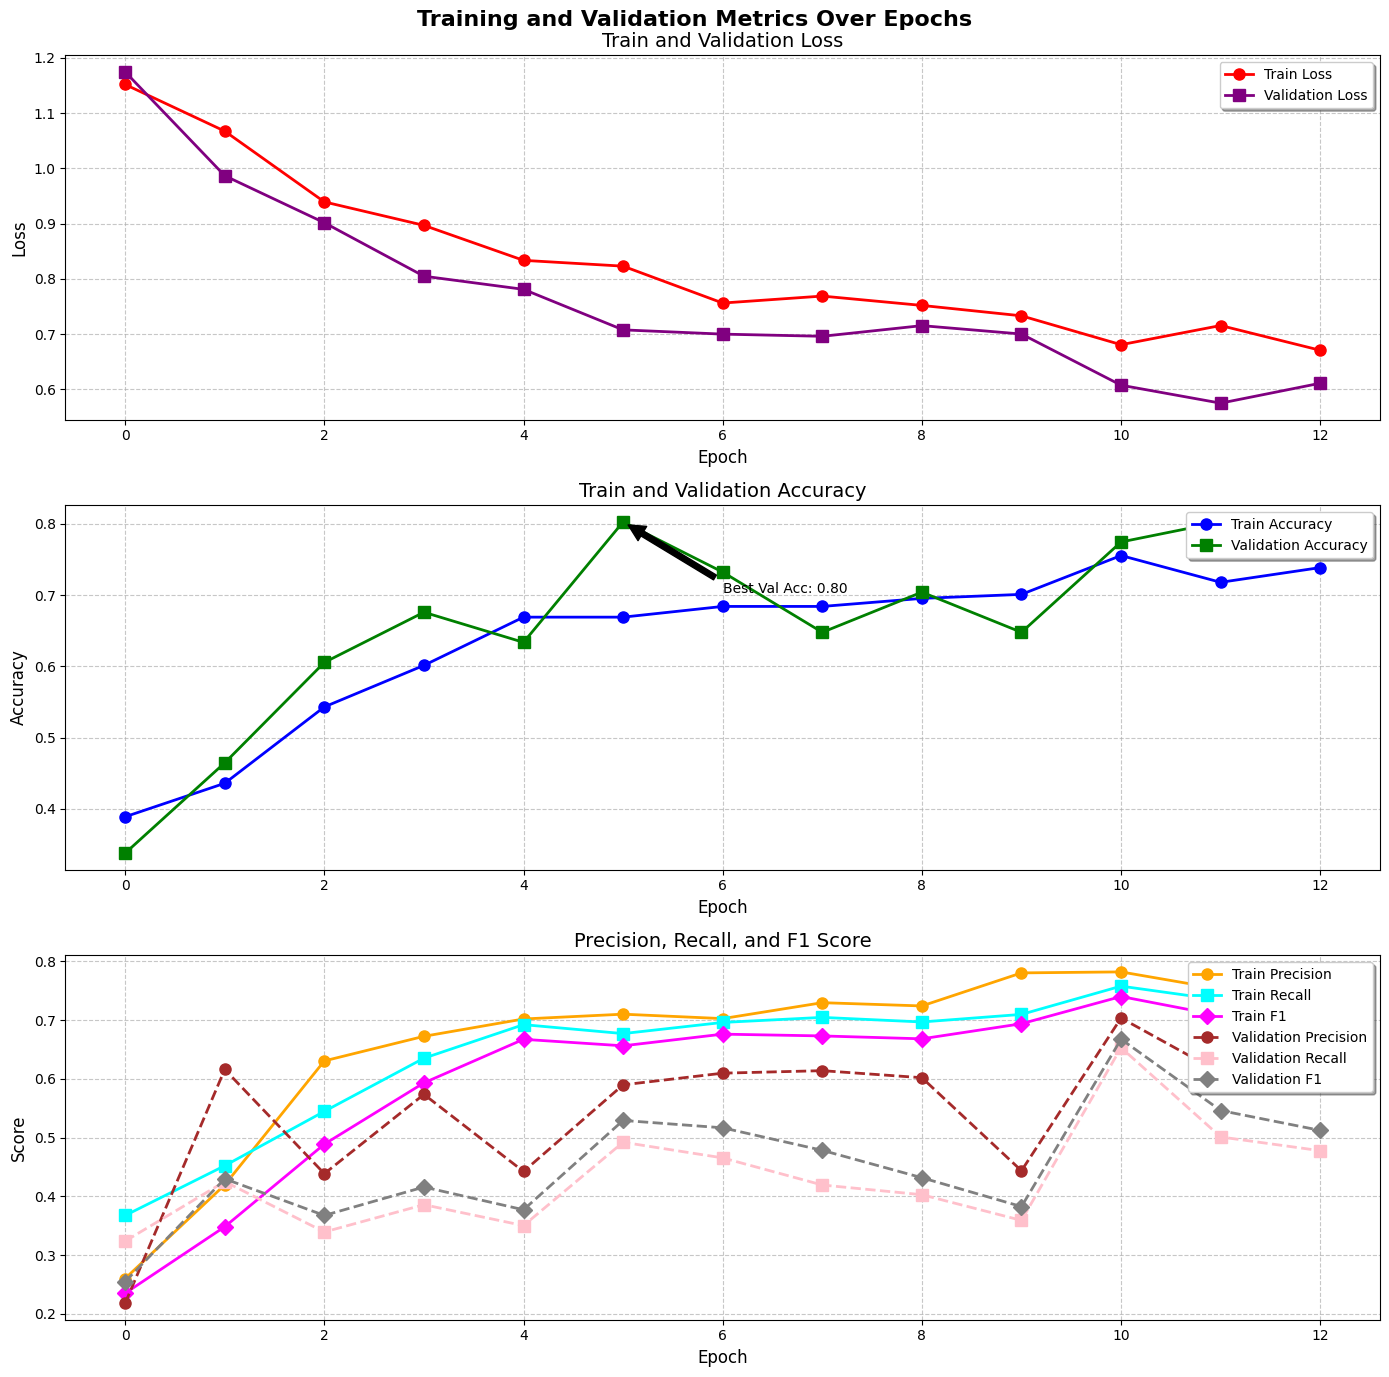

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_metrics(csv_directory, highest_version=None):
    # Find the highest version folder
    version_folders = [f for f in os.listdir(csv_directory) if f.startswith("version_")]
    if not version_folders:
        raise FileNotFoundError("No version folders found in the directory.")

    # Determine the highest version number
    if highest_version is None:
        highest_version = max(version_folders, key=lambda v: int(v.split('_')[1]))
    csv_path = os.path.join(csv_directory, str(highest_version), 'metrics.csv')

    # Load the CSV data into a DataFrame
    df = pd.read_csv(csv_path)

    # Replace empty strings with NaN and convert to appropriate data types for plotting
    df = df.replace('', float('nan'))

    # Group by epoch and calculate mean values for each epoch
    df_epoch = df.groupby('epoch').mean().reset_index()

    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(14, 14))
    fig.suptitle('Training and Validation Metrics Over Epochs', fontsize=16, fontweight='bold')

    # Plot 1: Train/Val Loss
    axes[0].plot(df_epoch['epoch'], df_epoch['train_loss_epoch'], label='Train Loss', marker='o', color='red', linestyle='-', linewidth=2, markersize=8)
    axes[0].plot(df_epoch['epoch'], df_epoch['val_loss'], label='Validation Loss', marker='s', color='purple', linestyle='-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Train and Validation Loss', fontsize=14)
    axes[0].legend(loc='upper right', fontsize=10, frameon=True, shadow=True, facecolor='white')
    axes[0].grid(True, linestyle='--', alpha=0.7)

    # Plot 2: Train/Val Accuracy
    axes[1].plot(df_epoch['epoch'], df_epoch['train_acc_epoch'], label='Train Accuracy', marker='o', color='blue', linestyle='-', linewidth=2, markersize=8)
    axes[1].plot(df_epoch['epoch'], df_epoch['val_acc'], label='Validation Accuracy', marker='s', color='green', linestyle='-', linewidth=2, markersize=8)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Train and Validation Accuracy', fontsize=14)
    axes[1].legend(loc='upper right', fontsize=10, frameon=True, shadow=True, facecolor='white')
    axes[1].grid(True, linestyle='--', alpha=0.7)

    # Add annotations for the best validation accuracy
    best_val_acc_epoch = df_epoch['val_acc'].idxmax()
    best_val_acc = df_epoch.loc[best_val_acc_epoch, 'val_acc']
    axes[1].annotate(f'Best Val Acc: {best_val_acc:.2f}', 
                     xy=(best_val_acc_epoch, best_val_acc), 
                     xytext=(best_val_acc_epoch + 1, best_val_acc - 0.1),
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     fontsize=10)

    # Plot 3: Precision, Recall, F1
    axes[2].plot(df_epoch['epoch'], df_epoch['train_precision_epoch'], label='Train Precision', marker='o', color='orange', linestyle='-', linewidth=2, markersize=8)
    axes[2].plot(df_epoch['epoch'], df_epoch['train_recall_epoch'], label='Train Recall', marker='s', color='cyan', linestyle='-', linewidth=2, markersize=8)
    axes[2].plot(df_epoch['epoch'], df_epoch['train_f1_epoch'], label='Train F1', marker='D', color='magenta', linestyle='-', linewidth=2, markersize=8)
    axes[2].plot(df_epoch['epoch'], df_epoch['val_precision'], label='Validation Precision', marker='o', color='brown', linestyle='--', linewidth=2, markersize=8)
    axes[2].plot(df_epoch['epoch'], df_epoch['val_recall'], label='Validation Recall', marker='s', color='pink', linestyle='--', linewidth=2, markersize=8)
    axes[2].plot(df_epoch['epoch'], df_epoch['val_f1'], label='Validation F1', marker='D', color='gray', linestyle='--', linewidth=2, markersize=8)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('Score', fontsize=12)
    axes[2].set_title('Precision, Recall, and F1 Score', fontsize=14)
    axes[2].legend(loc='upper right', fontsize=10, frameon=True, shadow=True, facecolor='white')
    axes[2].grid(True, linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage
plot_metrics('lightning_logs')